<a href="https://colab.research.google.com/github/3DLables/3DLabeler/blob/master/ResNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
from tqdm import tqdm
import os
from google.colab import drive
from scipy.ndimage import rotate
import random
from random import shuffle
import sys

drive.mount('/drive')
%cd /drive

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /drive
/drive


In [2]:
!pip install  https://github.com/3DLables/3DLabeler/archive/master.zip  
import ThreeDLabeler as td

     / 5.9MB 1.8MB/s
  Created wheel for ThreeDLabeler: filename=ThreeDLabeler-0.1.4-cp36-none-any.whl size=8418 sha256=a6a0ae0c7cfd738ad5b3b8b291e59d814b930b6836eb1724524fa8fbff2b0e86
  Stored in directory: /tmp/pip-ephem-wheel-cache-aetnjrnn/wheels/bf/17/fd/9bff15b364a3701f9ade6d41f38213bcefaf5dd3e2885a6d1c
Successfully built ThreeDLabeler


In [0]:
#basepath = '/drive/My Drive/Colab Notebooks/MouseSkulls/ReducedData/'
basepath = '/drive/My Drive/Colab Notebooks/MouseSkulls/ReducedData/'
file_list = os.listdir(basepath)
file_list = [i for i in file_list if i.endswith('.npy')]

In [4]:
voxels = []
points = []
for file in tqdm(file_list[:-1]): # -1 because of the model
    file = np.load(basepath+file, allow_pickle=True)
    voxels.append(file[0])
    points.append(file[1])

100%|██████████| 217/217 [02:11<00:00,  1.77it/s]


In [0]:
points = np.array(points)
voxels = np.array(voxels)
img = td.Image(voxels[0], points[0])

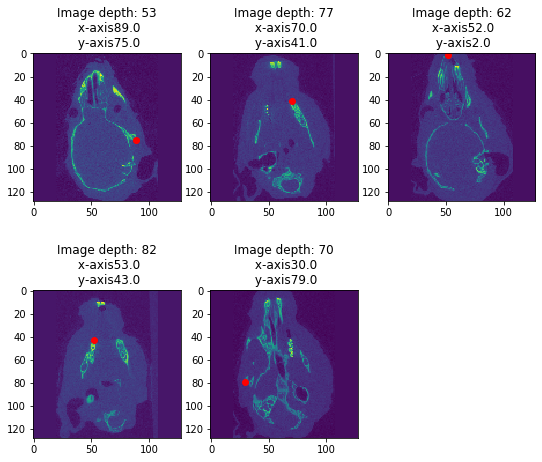

In [6]:
img.plot()

In [7]:
skulls = []

for i in tqdm(range(voxels.shape[0])):
    skull = td.Image(voxels[i], points[i])
    # skull = skull.scale(64) # because 128 is too large for numpy arrays
    skulls.append(skull)

100%|██████████| 217/217 [00:00<00:00, 55882.85it/s]


In [8]:
type(skulls[0])

ThreeDLabeler.images.Image

I'm turning them into images here because I want to keep the points and the voxels together. This is key for when I do my train test split. Further, it's important that we scale them down.

In [9]:
random.seed(42)
shuffle(skulls)
n_img = len(skulls)

train_mask = int(np.floor(n_img * 0.7))
test_mask = int(np.floor(n_img * 0.2))
print(test_mask)
print(train_mask)

43
151


In [10]:
train_skulls = skulls[:train_mask]
test_skulls = skulls[train_mask:(train_mask+test_mask)]
crossval_skulls = skulls[(train_mask + test_mask):]

print("The number of skulls in train, test and crossvalidation are",
      len(train_skulls), len(test_skulls), len(crossval_skulls))

The number of skulls in train, test and crossvalidation are 151 43 23


In [11]:
type(train_skulls[0])

ThreeDLabeler.images.Image

## Data Augmentation
This is far too few skulls to effectivly train a ML algorithm on. To fix this
issue, I'm rotating the images 6 times. This has to be done after the train/
test split because otherwise the test set would be *contaminated* by the images
that had already been trainined on. Giving an unrealistic metric of the performance of our ML algorithm. 

In [0]:
def rotate_skulls(skulls, rots=4):
    train_X = np.array(skulls)
    skull_list = []
    for i in tqdm(skulls):
        skull_list.append(i.img_transformer(rots))
    skull_list = np.array(skull_list).flatten()

    return skull_list

In [0]:
def reshape(skulls):
    """turns lists of skulls into np.arrays and makes them into the correct
    shape for tensorflow.
    
    We need to use np.append here because the conventional way ofusing an empty 
    list and then using list_name.append(i) only works in for smaller images
    for larger ones, this is too big and causes a runtime issue.

    So we use np.append instead which is honestly a really painful function in
    comparions but c'est la vie.
    """
    n_skulls = len(skulls)
    x0, x1, x2 = skulls[0].voxels.shape
    y0, y1 = skulls[0].point_position.shape
    train_X = np.zeros((n_skulls,x0, x1, x2))
    train_y = np.zeros((n_skulls, y0, y1))

    for i in tqdm(range(len(skulls))):
        train_X[i] = skulls[i].voxels
        train_y[i] = skulls[i].point_position
    # train_X = train_X.reshape((n_skulls, x0, x1, x2, 1))
    # train_y = train_y.reshape((n_skulls, y0*y1))
    return train_X, train_y


In [14]:
len(train_skulls)

151

In [0]:
import pickle
import sys
#list_size = pickle.dumps(train_skulls)
#list_size = np.round(sys.getsizeof(list_size) / 1e+9, 2)

In [0]:
print("The size of the list is:",list_size, "gigabytes")
print("This translates to",
      list_size * 4, 
      "if we rotate all the images",
      4, 'x')

The size of the list is: 2.53 gigabytes
This translates to 10.12 if we rotate all the images 4 x


In [16]:
train_skulls = rotate_skulls(train_skulls, rots=2) 
# This is so huge even test = np.zeros((3624, 128, 128, 128)) wil crash our run
# time.

100%|██████████| 151/151 [00:22<00:00,  6.74it/s]


In [0]:
#list_sizex4 = pickle.dumps(train_skulls)
#list_sizex4 = np.round(sys.getsizeof(list_sizex4) / 1e+9, 2)
#print("new list is", list_sizex4)

new list is 5.07


In [17]:
train_X, train_y = reshape(train_skulls)

100%|██████████| 302/302 [00:01<00:00, 252.93it/s]


In [0]:
VOXEL_DIMS = 128
TRAIN_SHAPE = train_X.shape[0]

In [0]:
train_X = train_X.reshape((TRAIN_SHAPE, VOXEL_DIMS, VOXEL_DIMS, VOXEL_DIMS, 1))
train_y = train_y.reshape((TRAIN_SHAPE, 15))

In [20]:
%tensorflow_version 2.x

TensorFlow 2.x selected.


Using TF2 and Keras we will build a resnet model based on the excelent coursera course by Andrew Ng.

In [0]:
import tensorflow as tf
from tensorflow.keras.layers import Add, Dense, Activation, ZeroPadding3D
from tensorflow.keras.layers import BatchNormalization, Flatten, Conv3D
from tensorflow.keras.layers import AveragePooling3D, MaxPooling3D, Input
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.initializers import glorot_uniform

In [0]:
def identity_block(X, f, filters, stage, block):
    """
    From Coursera shamelessly coppied...
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    Returns:
    X -- output of the identity block, tensor of shape (n_H, n_W, n_C)
    """
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    # Retrieve Filters
    F1, F2, F3 = filters

    # Save the input value.
    X_shortcut = X

    # First component of main path
    X = Conv3D(filters=F1, kernel_size=(1, 1, 1), strides=(1, 1, 1),
               padding='valid', name=conv_name_base + '2a',
               kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=-1, name=bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    # Second component of main path
    X = Conv3D(filters=F2, kernel_size=(f, f, f), strides=(1, 1, 1),
               padding='same', name=conv_name_base + '2b',
               kernel_initializer=glorot_uniform(seed=0))(X)

    X = BatchNormalization(axis=-1, name=bn_name_base + '2b')(X)
    X = X = Activation('relu')(X)

    X = Conv3D(filters=F3, kernel_size=(1, 1, 1), strides=(1, 1, 1),
               padding='same', name=conv_name_base + '2c',
               kernel_initializer=glorot_uniform(seed=0))(X)

    X = BatchNormalization(axis=-1, name=bn_name_base + '2c')(X)

    # Add shortcut value to main path, and pass it through a RELU activation
    X = Add()([X_shortcut, X])
    X = Activation('relu')(X)

    return X



In [0]:
def convolutional_block(X, f, filters, stage, block, s=2):
    """
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the
    main path
    filters -- python list of integers, defining the number of filters in the
    CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in
    the network
    block -- string/character, used to name the layers, depending on their
    position in the network
    s -- Integer, specifying the stride to be used
    Returns:
    X -- output of the convolutional block, tensor of shape (n_H, n_W, n_C)
    """
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    # Retrieve Filters
    F1, F2, F3 = filters

    # Save the input value
    X_shortcut = X
    # First component of main pathn

    X = Conv3D(F1, (1, 1, 1), strides=(s, s, s), padding='valid',
               name=conv_name_base + '2a',
               kernel_initializer=glorot_uniform(seed=0))(X)

    X = BatchNormalization(axis=-1, name=bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    # Second component of main path
    X = Conv3D(F2, (f, f, f), strides=(1, 1, 1), padding='same',
               name=conv_name_base + '2b',
               kernel_initializer=glorot_uniform(seed=0))(X)

    X = BatchNormalization(axis=-1, name=bn_name_base + '2b')(X)
    X = Activation('relu')(X)
    # Third component of main path
    X = Conv3D(F3, (1, 1, 1), strides=(1, 1, 1), padding='valid',
               name=conv_name_base + '2c',
               kernel_initializer=glorot_uniform(seed=0))(X)

    X = BatchNormalization(axis=-1, name=bn_name_base + '2c')(X)
    # SHORTCUT PATH ####
    X_shortcut = Conv3D(F3, (1, 1, 1), strides=(s, s, s), padding='valid',
                        name=conv_name_base + '1',
                        kernel_initializer=glorot_uniform(seed=0))(X_shortcut)

    X_shortcut = BatchNormalization(
        axis=-1, name=bn_name_base + '1')(X_shortcut)
    # Add shortcut value to main path, and pass it through a RELU activation
    X = Add()([X_shortcut, X])
    X = Activation('relu')(X)

    return X



In [0]:
def ResNet50(input_shape=(64, 64, 64, 1), classes=15):  # Classes need to be fixed
    """
    Implementation of the popular ResNet50 the following architecture:
    Conv3D -> BATCHNORM -> RELU -> MAXPOOL -> CONVBLOCK -> IDBLOCK*2 ->
    CONVBLOCK -> IDBLOCK*3
    -> CONVBLOCK -> IDBLOCK*5 -> CONVBLOCK -> IDBLOCK*2 -> AVGPOOL -> TOPLAYER
    Arguments:
    input_shape -- shape of the images of the dataset
    classes -- integer, number of classes
    Returns:
    model -- a Model() instance in Keras
    """
    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)
    # Zero-Padding
    X = ZeroPadding3D((3, 3, 3))(X_input)
    # Stage 1
    X = Conv3D(64, (7, 7, 7), strides=(2, 2, 2), name='conv1',
               kernel_initializer=glorot_uniform(seed=0))(X)

    X = BatchNormalization(axis=-1, name='bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling3D((3, 3, 3), strides=(2, 2, 2))(X)
    # Stage 2
    X = convolutional_block(
        X, f=3, filters=[64, 64, 256], stage=2, block='a', s=1)
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')

    # Stage 3
    X = convolutional_block(
        X, f=3, filters=[128, 128, 512], stage=3, block='a', s=2)
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='b')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='c')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='d')
    # Stage 4
    X = convolutional_block(
        X, f=3, filters=[256, 256, 1024], stage=4, block='a', s=2)
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='c')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='d')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='e')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='f')
    # Stage 5
    X = convolutional_block(
        X, f=3, filters=[512, 512, 2048], stage=5, block='a', s=2)
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='b')
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='c')
    # AVGPOOL
    X = AveragePooling3D(pool_size=(2, 2, 2), name="avg_pool")(X)
    # output layer
    X = Flatten()(X)

    X = Dense(classes)(X)
    # Create model
    model = Model(inputs=X_input, outputs=X, name='ResNet50')
    return model


In [0]:
resnet_model = ResNet50(input_shape=(VOXEL_DIMS, VOXEL_DIMS, VOXEL_DIMS, 1))

In [0]:
resnet_model.compile(loss='mean_squared_error',
                optimizer='adam',
                metrics=['mae', "mean_squared_error"])

In [27]:
resnet_hist = resnet_model.fit(train_X, 
                               train_y, 
                               epochs=100, 
                               batch_size=12)

Train on 302 samples
Epoch 1/100
302/302 [==============================] - 44s 147ms/sample - loss: 668.6488 - mae: 17.8772 - mean_squared_error: 668.6489
Epoch 2/100
302/302 [==============================] - 23s 78ms/sample - loss: 295.1690 - mae: 11.6550 - mean_squared_error: 295.1689
Epoch 3/100
302/302 [==============================] - 23s 78ms/sample - loss: 216.5753 - mae: 10.1275 - mean_squared_error: 216.5753
Epoch 4/100
302/302 [==============================] - 24s 78ms/sample - loss: 191.6527 - mae: 9.4900 - mean_squared_error: 191.6527
Epoch 5/100
302/302 [==============================] - 23s 78ms/sample - loss: 154.3319 - mae: 8.5723 - mean_squared_error: 154.3319
Epoch 6/100
302/302 [==============================] - 23s 78ms/sample - loss: 121.2666 - mae: 7.6451 - mean_squared_error: 121.2665
Epoch 7/100
302/302 [==============================] - 23s 78ms/sample - loss: 128.9757 - mae: 8.0130 - mean_squared_error: 128.9757
Epoch 8/100
302/302 [=======================

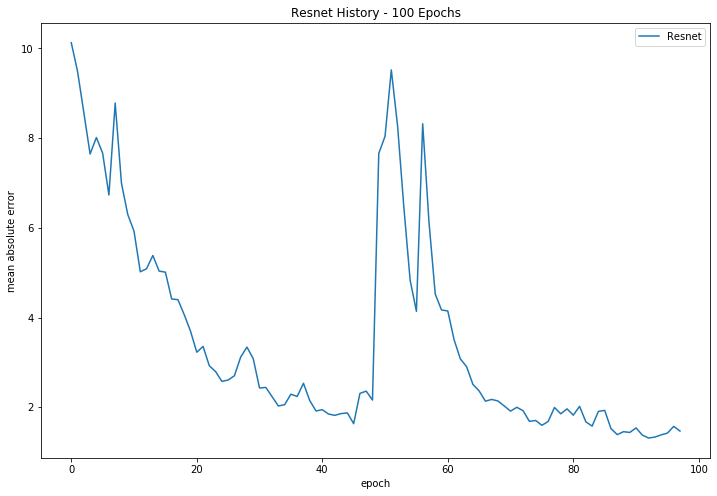

In [29]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,8))
plt.plot(resnet_hist.history['mae'][2:], label='Resnet')

plt.title('Resnet History - 100 Epochs')
plt.legend(loc='upper right')
plt.xlabel('epoch')
plt.ylabel('mean absolute error')
plt.show()

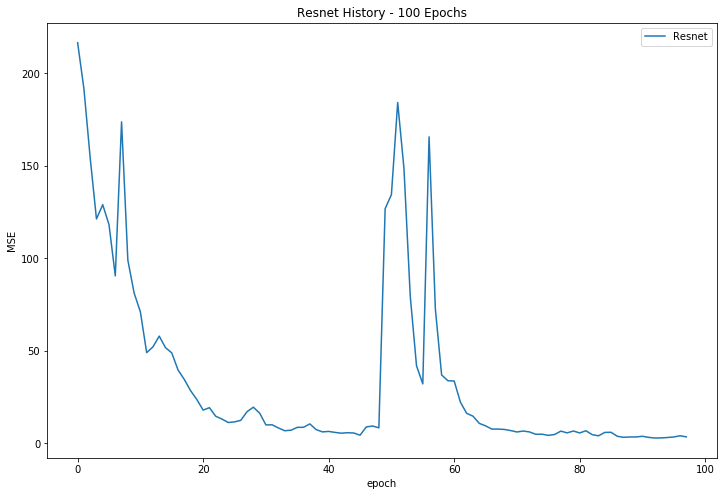

In [30]:
plt.figure(figsize=(12,8))
plt.plot(resnet_hist.history['loss'][2:], label='Resnet')

plt.title('Resnet History - 100 Epochs')
plt.legend(loc='upper right')
plt.xlabel('epoch')
plt.ylabel('MSE')
plt.show()

In [0]:
 # https://www.tensorflow.org/tutorials/keras/save_and_load
 resnet_model.save(basepath+"resnetmodel_128x2.h5")

In [0]:
# resnet_model = tf.keras.models.load_model(basepath+'resnetmodel.h5')


## Model Validation

In [0]:
# test_skulls = rotate_skulls(test_skulls)

100%|██████████| 43/43 [00:05<00:00,  7.74it/s]


In [31]:
test_X, test_y = reshape(test_skulls)

100%|██████████| 43/43 [00:00<00:00, 247.01it/s]


In [0]:
test_X = test_X.reshape((test_X.shape[0], VOXEL_DIMS, VOXEL_DIMS, VOXEL_DIMS, 1))
test_y = test_y.reshape((test_y.shape[0], 15))

In [35]:
model_eval = resnet_model.evaluate(test_X, test_y, batch_size=32)

43/43 [==============================] - 1s 25ms/sample - loss: 154.5583 - mae: 6.9088 - mean_squared_error: 154.5583


This is significanlty higher than our training loss which means we are most likely over fitting.

In [0]:
preds = resnet_model.predict(test_X)
test_len = test_X.shape[0]
test_X_vox = test_X.reshape(test_len, VOXEL_DIMS, VOXEL_DIMS, VOXEL_DIMS)
test_y_points = test_y.reshape((test_len, 5, 3))
pred_points = preds.reshape((test_len, 5, 3))

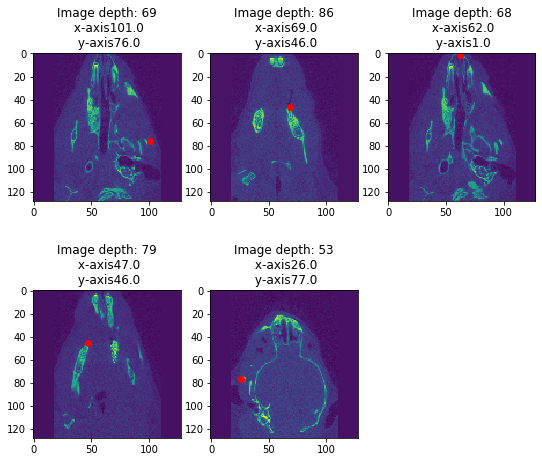

In [39]:
idx = 25 # more or less random. I chose one that looked more legible
td.Image(test_X_vox[idx], test_y_points[idx]).plot()

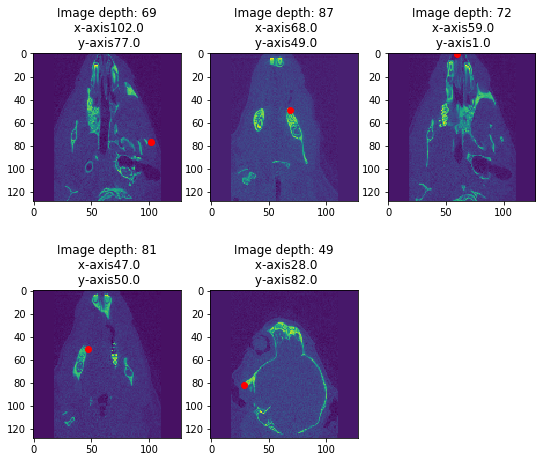

In [40]:
td.Image(test_X_vox[idx], pred_points[idx]).plot()

In [42]:
print('Actual Values\n\n',
      test_y_points[idx],
      '\n\nPredicted Values\n\n',
      pred_points[idx])

Actual Values

 [[100.60844998  68.98114475  76.26117293]
 [ 68.6075676   85.84977354  45.99940653]
 [ 62.28509183  67.52104108   1.14487586]
 [ 46.91452068  78.78485702  45.62173831]
 [ 26.30076928  53.1605379   76.6233019 ]] 

Predicted Values

 [[101.67841    68.81029    76.75709  ]
 [ 68.096115   87.491      48.651814 ]
 [ 59.39053    72.08004     0.8635349]
 [ 47.182903   81.28902    50.490364 ]
 [ 28.25661    48.84822    81.66293  ]]


In [0]:
resnet_model.summary()

Model: "ResNet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 128, 128, 12 0                                            
__________________________________________________________________________________________________
zero_padding3d_2 (ZeroPadding3D (None, 134, 134, 134 0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv3D)                  (None, 64, 64, 64, 6 22016       zero_padding3d_2[0][0]           
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 64, 64, 64, 6 256         conv1[0][0]                      
___________________________________________________________________________________________

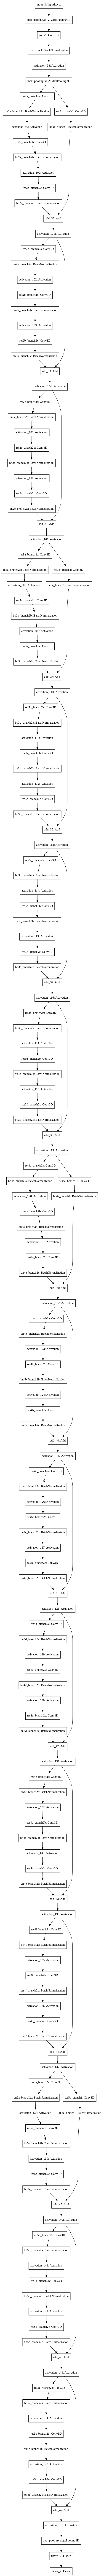

In [0]:
tf.keras.utils.plot_model(resnet_model, to_file=basepath+"model.png")

ValueError: ignored